In [1]:
import pandas as pd 
import numpy as np
import warnings 
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df = df.drop('qid',axis = 1)
df

,question_text,target
0,How did Quebec nationalists see their province...,0
1,"Do you have an adopted dog, how would you enco...",0
2,Why does velocity affect time? Does velocity a...,0
3,How did Otto von Guericke used the Magdeburg h...,0
4,Can I convert montra helicon D to a mountain b...,0
...,...,...
1306117,What other technical skills do you need as a c...,0
1306118,Does MS in ECE have good job prospects in USA ...,0
1306119,Is foam insulation toxic?,0
1306120,How can one start a research project based on ...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   question_text  1306122 non-null  object
 1   target         1306122 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 19.9+ MB


**No null values**

In [5]:
df['target'].value_counts()

target
0    1225312
1      80810
Name: count, dtype: int64

In [6]:
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

df['question_text'] = df['question_text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Preprocessing skips stemming to match words with GloVe vectors, maintaining original word forms**

In [7]:
# Splitting the entire data into training and validation

from sklearn.model_selection import train_test_split

X = df['question_text']
y = df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Calculate the 95th percentile of sentence lengths in words to determine the maximum sequence length for X_train.

import numpy as np

sequence_lengths = [len(s.split()) for s in X_train]  
max_length = int(np.percentile(sequence_lengths, 95))

print(max_length)

14


**After that we will convert the words in sentences into tokens and pad the sequences of the text column upto max_length**

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen= max_length)
X_val_pad = pad_sequences(X_val_seq, maxlen= max_length)


In [10]:
X_train_pad[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    2,   17,
       1654,  223,  313])

**Below is the code which maps words to GloVe vectors for neural networks**

In [11]:
embeddings_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [12]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.14432999,  0.43950999,  0.58323997, ...,  0.50133997,
         0.49535999,  0.49919999],
       [ 0.13888   ,  0.19702999,  0.69613999, ..., -0.41385001,
         0.72303998,  0.88176   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.64279002, -0.36793   , -0.091621  , ..., -0.1437    ,
        -0.10973   , -0.85073   ]])

In [13]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,100,trainable=False,)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

In [14]:
# Basic TensorFlow model for binary text classification with an LSTM layer and early stopping

import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.Sequential([
    Input(shape=(None,), dtype="int32"),
    embedding_layer, 
    layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 100)      │    21,794,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,887,557 (83.49 MB)

 Trainable params: 21,887,557 (83.49 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    X_train_pad, 
    y_train, 
    validation_data=(X_val_pad, y_val), 
    batch_size=512, 
    epochs=5,
    callbacks=[early_stopping]
)

Epoch 1/5
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 294s 142ms/step - accuracy: 0.9454 - loss: 0.1505 - val_accuracy: 0.9563 - val_loss: 0.1106
Epoch 2/5
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 292s 143ms/step - accuracy: 0.9571 - loss: 0.1065 - val_accuracy: 0.9568 - val_loss: 0.1076
Epoch 3/5
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 287s 140ms/step - accuracy: 0.9618 - loss: 0.0945 - val_accuracy: 0.9570 - val_loss: 0.1113
Epoch 4/5
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 284s 139ms/step - accuracy: 0.9666 - loss: 0.0826 - val_accuracy: 0.9564 - val_loss: 0.1142
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


In [16]:
# test loss and test accuarcy 
test_loss, test_accuracy = model.evaluate(X_val_pad, y_val)
print(f"Test Accuracy: {test_accuracy:.2f}")

8164/8164 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9563 - loss: 0.1083
Test Accuracy: 0.96


**Test Accuracy: 0.96**

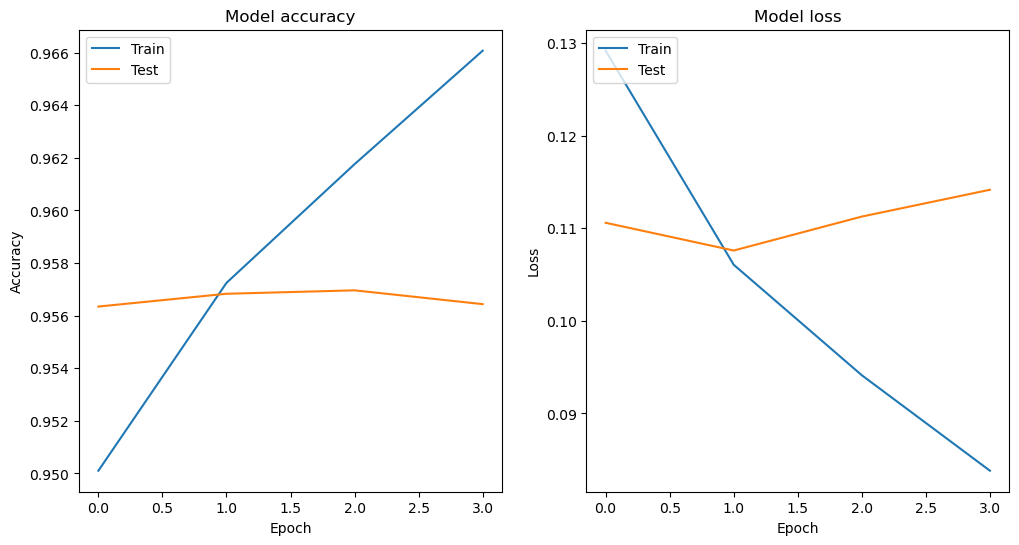

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


In [18]:
model.save('Model_Qoura.keras')